In [0]:
from google.colab import drive,files

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Imports go here

import numpy as np
import pandas as pd
import os
import glob
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras.models import Sequential
from keras import layers
import functools
import keras
from keras import backend as K
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
# Read the annotated recipe files as input from the directory on drive.

directory = '/content/drive/My Drive/ANLP-Final-Project-Submission/recipe_corpus_annotated_469/'
os.chdir(directory)
files = [f for f in os.listdir(directory)]

In [0]:
# Looping through all the recipe files and prepare list of all filenames,pair of word and its corresponding label and 
# the vocabulary list for the entire food corpus as we read the recipe files

wordlabelpairs = []
annotated_filenames = []
vocablist = []

for f in files:
    content = open(f,'r')
    annotated_filenames.append(f)
    tuplelist = []
    for line in content:
          word = line.strip().split(" ")[0]
          label = line.strip().split(" ")[1]
          pair = tuple((word,label))
          tuplelist.append(pair)
          vocablist.append(word)
    wordlabelpairs.append(tuplelist)

In [0]:
# Check for the length of the list of annotated files and wordlabelpairs.They should be equal to the number of files read wghich is 469.
print(len(annotated_filenames))
print(len(wordlabelpairs))

469
469


In [0]:
# We plan to segregate the entire corpus into sentences.So, we read each list of wordlabel pair and segregate them as sentences based on the sentence_start marker.
# This marker is placed in each annotated file after the text recipe is processed through nlp pipeline and sentences are created.We are populating a global data structure
# called sentence matrix to collect all the distinct sentences in the corpus.

sentencematrix = []

for list in wordlabelpairs:
  sentence = []
  for pair in list:
    if (pair[0] == 'sentence_start' and len(sentence) == 0):
      continue
    elif (pair[0] == 'sentence_start' and len(sentence) != 0):
      sentencematrix.append(sentence)
      sentence.clear()
      continue
    else :
      sentence.append(pair)
  
  sentencematrix.append(sentence)

In [0]:
# Check for the total number of sentences in the corpus
print(len(sentencematrix))

3936


In [0]:
# Building vocabulary of all the words in all the files.Vocab size is 2763
words= set(vocablist)
print(len(words))

tags = set(['O','B-OTH'])
n_tags = len(tags)

2763


In [0]:
# Finding the maximum length sentence in the corpus

max_len =  max(len(sent) for sent in sentencematrix)
print("largest length sentence has words : " + str(max_len))

largest length sentence has words : 50


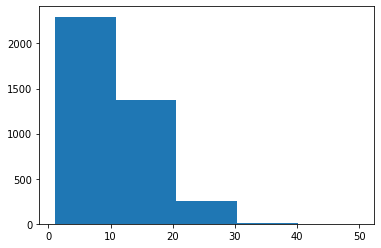

In [0]:
# plot to seen the length distribution of sentences.

%matplotlib inline
plt.hist([len(sent) for sent in sentencematrix], bins= 5)
plt.show()

In [0]:
# We can see that the max length of a sentence is 50.So, we can fix the length to 52 and pad the other sentences to this length.This is because the input should be of same length to 
# LSTM models.
max_len = 52

In [0]:
# creating an index for all the vocabulary words and for the labels.

words2index = {w:i for i,w in enumerate(words)}
tags2index = {'B-OTH': 1, 'O': 0}

In [0]:
# We are looping through the sentences and padding them with "PADword" to meet the length criteria of 52.Also, each sentence is an input X to the model.

X = [[w[0] for w in s] for s in sentencematrix]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[0]

['serve',
 'with',
 'tortilla',
 'chips',
 'for',
 'dipping',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [0]:
# The Y will also have the same dimension as X as we are giving the model the label for every word in the corpus during training.So, we pad Y with "0" till the length of 52.
# Y will have value 0 or 1 for non-ingedient or ingredient.

y = [[tags2index[w[1]] for w in s] for s in sentencematrix]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[11]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [0]:
# Splitting the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [0]:
# Checking for the train and test size.

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

3542
394
3542
394


In [0]:
# Defining the batch size and the session

batch_size = 30
sess = tf.Session()
K.set_session(sess)

In [0]:
# Downloading the Elmo Embedding

elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [0]:
# Defining the embedding function.

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [0]:
# Defing the neural network model

input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
# Slicing the train and validation for fitting all the samples into batch size of 30.

X_train, X_val = X_train[:90*batch_size], X_train[-20*batch_size:]
y_train, y_val = y_train[:90*batch_size], y_train[-20*batch_size:]
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

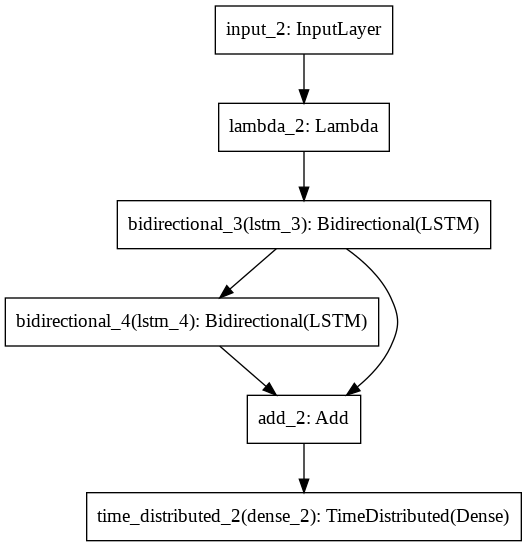

In [0]:
# Defining the loss function as sparse_categorical_crossentropy as it is a multi-class classification and the output y is sparse.

model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
plot_model(model, to_file='ELMO with LSTM.png') # plot graph

In [0]:
# Training the model for batch size 30 and evaluating on validation set.

history = model.fit(np.array(X_train), y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2700 samples, validate on 600 samples
Epoch 1/5



2700/2700 [==============================] - 73s 27ms/step - loss: 0.0269 - acc: 0.9930 - val_loss: 0.0053 - val_acc: 0.9983
Epoch 2/5
2700/2700 [==============================] - 66s 24ms/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.0016 - val_acc: 0.9996
Epoch 3/5
2700/2700 [==============================] - 66s 25ms/step - loss: 9.0702e-04 - acc: 0.9999 - val_loss: 5.3084e-04 - val_acc: 0.9998
Epoch 4/5
2700/2700 [==============================] - 66s 25ms/step - loss: 2.4677e-04 - acc: 1.0000 - val_loss: 4.5065e-04 - val_acc: 0.9999
Epoch 5/5
2700/2700 [==============================] - 66s 24ms/step - loss: 9.8004e-05 - acc: 1.0000 - val_loss: 2.3353e-04 - val_acc: 0.9999


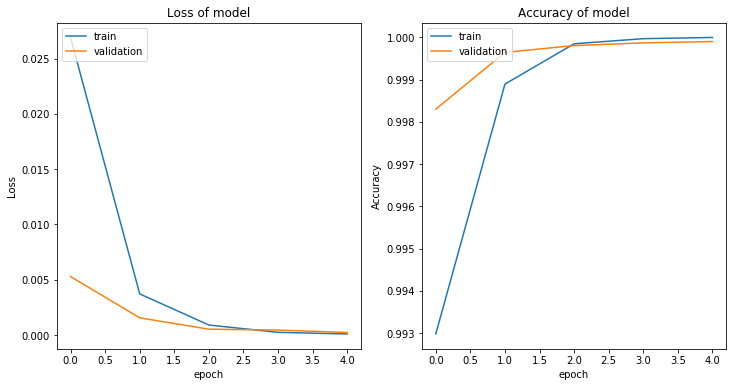

In [0]:
# Plotting the train,validation accuracy and loss statistics for the model

fig = plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### Validating the model on test set with Validation metrics like Precision,Recall and F1.

In [0]:
# Prediction on test

X_test_slice = X_test[:1*batch_size]
X_test_slice = np.array(X_test_slice)

test_pred = model.predict(X_test_slice, verbose=1)

30/30 [==============================] - 1s 50ms/step


In [0]:
# Changing the predicted output from probabilities to label of 1 and 0 in a numpy array of shape 30,52(sample size,dimension)

predictions_ingredients=1*(test_pred >= 0.5)

predicts = []
for row in predictions_ingredients:
  label = []
  for classification in row:
    if(classification[0] == 1):
       label.append(0)
    else :
       label.append(1)
  predicts.append(label)

predictions = np.array(predicts)

In [0]:
y_expected = y_test[:1*batch_size]

30


In [0]:
# Retreiving the precison,recall and f1-score of the model

from sklearn.metrics import classification_report
print(classification_report(y_expected, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
